# Fuel Price Modelling

This notebook runs through the code used to select the best model to predict future petrol prices

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn
import pickle
import math
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from itertools import chain
from itertools import combinations
from itertools import product
register_matplotlib_converters()

# Constants
CURRENT_LOCATION = (-33.9693, 151.0697)

# Get data
all_data = pd.read_csv('data/interim/all_data_cleaned.csv')
all_data['last_updated'] = pd.to_datetime(all_data['last_updated'], format='%Y-%m-%d %H:%M:%S')

# Data preprocessing - functions for generating features custom features
def new_month_radial_basis(x, m=1, cycle=30.4375, alpha=100):
    diff = min(x-m, cycle - x + m)
    return np.mod(np.exp(-1/(2*alpha)*(diff)**2), cycle, dtype=np.float32)

def new_year_radial_basis(x, m=1, cycle=365.25, alpha=100):
    diff = min(x-m, cycle - x + m)
    return np.mod(np.exp(-1/(2*alpha)*(diff)**2), cycle, dtype=np.float32)

def idxmax(series, window):
    """
    For each value in `series`, look at the past `window` values. It finds which row had the 
    maximum value and returns the index of that value.
    """
    i = 0
    while i + window <= len(series):
        yield(series.iloc[i:i+window].idxmax())
        i += 1
        
def idxmin_centre(series, window):
    """
    For each value in `series`, look at the past `window` values. It finds which row had the 
    maximum value and returns the index of that value.
    """
    half_window = int(window/2)
    i = half_window
    while i + half_window <= len(series):
        yield(series.iloc[i-half_window:i+half_window].idxmin())
        i += 1
        
# Helper functions
def possible_selections(ss):
    """
    For a list containing n elements, returns all possible combinations of size m where m = 1, 2, ..., n
    """
    return list(chain(*map(lambda x: combinations(ss, x), range(0, len(ss) + 1))))

def train_test_split_by_time(X, y, test_size=0.1, **kwargs):
    """
    If the train-test split shouldn't be done randomly but rather it should be split with past and 
    future values then this function will split the data that way
    """
    if test_size < 1:
        train_size = 1 - test_size
        total_length = len(X)
        split = round(train_size*total_length)
        X_train = X.iloc[:split, :]
        X_test = X.iloc[split:, :]
        y_train = y.iloc[:split, :]
        y_test = y.iloc[split:, :]
        return X_train, X_test, y_train, y_test
    else:
        split = len(X) - test_size
        X_train = X.iloc[:split, :]
        X_test = X.iloc[split:, :]
        y_train = y.iloc[:split, :]
        y_test = y.iloc[split:, :]
        return X_train, X_test, y_train, y_test        

def weighted_average(column, weights):
    """
    Usage: df.groupby(groups).apply(weighted_average(column_to_aggregate, weights_to_use))
    """
    def inner(group):
        return (group[column] * group[weights]).sum() / group[weights].sum()
    inner.__name__ = 'wtd_avg'
    return inner

def distance_calculator(first, second):
    """
    Calculates the distance between the first point and the second point.
    First and second must be in the form of a tuple (x, y)
    The inputs should be in degrees as the function will convert it to radians
    Output is in kilometres
    """
    first = (math.radians(first[0]), math.radians(first[1]))
    second = (math.radians(second[0]), math.radians(second[1]))
    return 6371.01 * math.acos(math.sin(first[0])*math.sin(second[0]) + math.cos(first[0])*math.cos(second[0])*math.cos(first[1] - second[1]))

# Data preprocessing - set date frequency to daily
all_data['date'] = all_data['last_updated'].dt.round('D')

# Data preprocessing - calculate weights for distance
all_data['distance'] = all_data[['loc_latitude', 'loc_longitude']].apply(lambda x: distance_calculator(CURRENT_LOCATION, x), axis=1)
all_data['distance_weights'] = 1/all_data['distance']

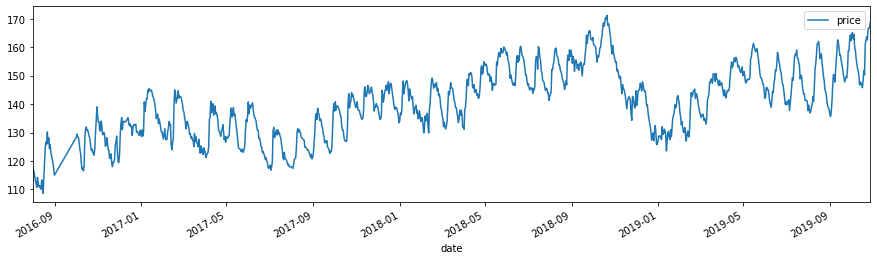

In [2]:
# Data visualised
all_data.pivot_table(index='date', values='price').plot(figsize=(15, 4));

In [3]:
# Parameters
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

class FuelPricePredictor:
    """
    List of additional features that can be used: new_month,
    new_year, days_since_last_max, days_since_last_max_sq
    """
    def __init__(self, library_model=LinearRegression, fuel_type='E10', lags=80,
                 predictions=60, test_size=0.1, train_test_split=train_test_split,
                 features=[], baseline=False, min_date='2000-01-01', max_date='2099-01-01',
                 sample=None, new_month_alpha=100, new_year_alpha=100, location_weights=False):
        self.library_model = library_model
        self.fuel_type = fuel_type
        self.lags = lags
        self.predictions = predictions
        self.test_size = test_size
        self.features = features
        self.baseline = baseline
        self.train_test_split = train_test_split
        self.min_date = min_date
        self.max_date = max_date
        self.sample = sample
        self.new_month_alpha = new_month_alpha
        self.new_year_alpha = new_year_alpha
        self.location_weights = location_weights

    def _generate_features(self, data):
        self.feature_labels = ['price'] + [f'price({-i})' for i in range(1, self.lags)]
        for i in range(1, self.lags):
            data[f'price(-{i})'] = data['price'].shift(i)
        if 'new_month' in self.features:
            self.feature_labels += ['new_month']
            data['new_month'] = data.index.day.map(lambda x: new_month_radial_basis(x, alpha=self.new_month_alpha))
        if 'new_year' in self.features:
            self.feature_labels += ['new_year']
            data['new_year'] = data.index.day.map(lambda x: new_year_radial_basis(x, alpha=self.new_year_alpha))
        if 'days_since_last_max' in self.features:
            self.feature_labels += ['days_since_last_max']
            window = 30
            data['last_max_date'] = pd.Series(idxmax(data['price'], window), index=data.index[window-1:])
            data['days_since_last_max'] = (data.index - data['last_max_date']).dt.days
        if 'days_since_last_max_sq' in self.features:
            self.feature_labels += ['days_since_last_max_sq']
            window = 30
            data['last_max_date'] = pd.Series(idxmax(data['price'], window), index=data.index[window-1:])
            data['days_since_last_max'] = (data.index - data['last_max_date']).dt.days
            data['days_since_last_max_sq'] = data['days_since_last_max']**2
        return data
            
    def _generate_targets(self, data):
        self.target_labels = [f'price({i})' for i in range(1, self.predictions+1)]
        for i in range(1, self.predictions+1):
            data[f'price({i})'] = data['price'].shift(-i)
        return data
    
    def fit(self, data):
        # Filter data by `fuel_type`
        data = data[data['fuel_type'] == self.fuel_type]
        
        # Select specific date range
        data = data[data['date'] > self.min_date]
        data = data[data['date'] < self.max_date]
        
        if self.location_weights:
            data = data.groupby('date').apply(weighted_average('price', 'distance_weights'))
            data = pd.DataFrame(data, columns=['price'])
        else:
            data = data.pivot_table(index='date', values='price', aggfunc='mean')
        self.data = data
            
        # Create features and targets
        data = self._generate_features(data)
        data = self._generate_targets(data)
        data = data.dropna(how='any')
        
        # Split data to training and test set
        self.X_train, self.X_test, self.y_train, self.y_test = self.train_test_split(data[self.feature_labels], data[self.target_labels], 
                                                                                     test_size=self.test_size, random_state=42, shuffle=True)
        
        # Resample if needed
        if self.sample:
            self.X_train = self.X_train.sample(int(len(self.X_train)*self.sample), random_state=40, replace=True)
            self.y_train = self.y_train.sample(int(len(self.y_train)*self.sample), random_state=40, replace=True)
        
        # Baseline model
        if self.baseline:
            self.y_preds = self.y_test.copy()
            for column in self.y_preds:
                self.y_preds.loc[:, column] = self.X_test.mean(axis=1)
            self.mean_square_error = ((self.y_preds - self.y_test)**2).mean(axis=1)**(1/2)
            self.mean_square_error = self.mean_square_error.mean()
        else:
            self.model = self.library_model()
            self.model.fit(self.X_train, self.y_train)
            self.y_preds = self.model.predict(self.X_test)
            self.y_preds = pd.DataFrame(self.y_preds, index=self.y_test.index, columns=self.y_test.columns)
        
        # Get residuals
        self.residuals = self.y_preds - self.y_test
        
        # Get test mean square error
        self.mean_square_error = ((self.y_preds - self.y_test)**2).mean(axis=1)**(1/2)
        self.mean_square_error = self.mean_square_error.mean()
    
    def predict(self, data, start_date='2016-01-01', end_date='2099-01-01', overlay_actuals=False, plot=False, minimum=False):
        # Prepare data
        data = data[data['fuel_type'] == self.fuel_type]
        data = data.pivot_table(index='date', values='price', aggfunc='mean')

        # Filter historical data within desired range
        plot_data = data[(data.index > start_date) & (data.index < end_date)]
        
        # Get prediction range
        last_date = plot_data.index.max()
        start_prediction_date = last_date + pd.Timedelta(1, 'D')
        predicted_date_range = pd.date_range(start=start_prediction_date, periods=self.predictions, freq='D')
        end_prediction_date = predicted_date_range.max()
        
        # Generate features
        formatted_data = self._generate_features(plot_data.copy())
        formatted_data = formatted_data.loc[:, self.feature_labels]
        formatted_data = formatted_data.dropna(how='any')
        
        # Get last row only
        formatted_data = formatted_data.iloc[[-1], :]
        self.formatted_data = formatted_data
        
        # Fit baseline model
        if self.baseline:
            mean = self.formatted_data.mean(axis=1).values[0]
            self.predicted_values = pd.DataFrame(index=predicted_date_range, columns=['price'])
            for date in self.predicted_values.index:
                self.predicted_values.loc[date, :] = mean
        else:
            # Output and format results
            self.predicted_values = self.model.predict(formatted_data)
            self.predicted_values = pd.DataFrame(self.predicted_values.flatten(), index=predicted_date_range, columns=['price'])

        # Plot results
        if plot:
            plt.figure(figsize=(12, 4))
            plt.plot(plot_data, label='Historical data')
            plt.plot(self.predicted_values, label='Predicted data')
            plt.xlabel('Date')
            plt.ylabel('Price (cents)')

        # Overlay actuals over the predicted values
        self.actuals = data.loc[(data.index >= start_prediction_date) & (data.index <= end_prediction_date), :]
        if plot and overlay_actuals:
            plt.plot(self.actuals, label='Actuals')
        
        # Indicate minimums
        if minimum:
            minimum_values = pd.Series(list(idxmin_centre(self.predicted_values['price'], window=20)))
            minimum_values = minimum_values.value_counts()
            minimum_values = minimum_values[minimum_values > 4]
            minimum_values = minimum_values.index
            minimum_values = model.predicted_values.loc[minimum_values, :]
            plt.scatter(minimum_values.index, minimum_values, c='red', alpha=0.8)
            for index, row in minimum_values.iterrows():
                date_as_string = pd.datetime.strftime(index, format='%d %B')
                print(f'On {date_as_string}, there will be a minimum price of {row[0]:,.2f} cents')
            
        # Put in a legend
        if plot:
            plt.legend(loc='lower left')
            
        # Development error
        self.dev_mean_square_error = ((self.predicted_values - self.actuals)**2).mean(axis=0)**(1/2)
        self.dev_mean_square_error = self.dev_mean_square_error.values[0]


Baseline model error is 8.757973700990972


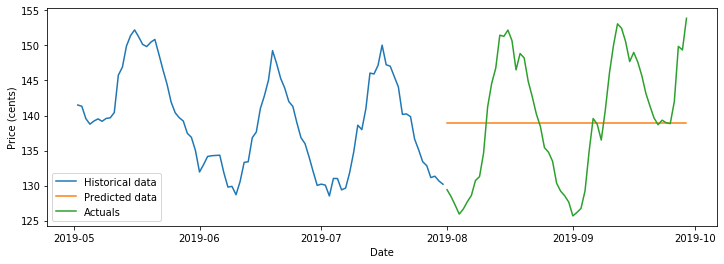

In [4]:
baseline_model = FuelPricePredictor(baseline=True)
baseline_model.fit(all_data)
baseline_model.predict(all_data, start_date='2019-05-01', end_date='2019-08-01', plot=True, overlay_actuals=True)
#plt.savefig('screenshots/baseline_model')
print('Baseline model error is', baseline_model.dev_mean_square_error)

In [53]:
# Write down all possible models to try out
params = {'library_model': [LinearRegression, Lasso],
          'test_size': [0.1, 0.2, 0.3, 0.4, 30, 60, 90, 120],
          'features': ['new_month', 'days_since_last_max', 'days_since_last_max_sq', 'new_year'],
          'train_test_split': [train_test_split, train_test_split_by_time],
          'min_date': ['2016-10-01', '2017-01-01', '2017-04-01', '2017-07-01', '2017-10-01', '2018-01-01', '2018-04-01', '2018-07-01'],
          'max_date': ['2019-07-01'],
          'sample': [1, 1.25, 1.5],
          'location_weights': [False],
          }

# Gets all possible combinations of features
if 'features' in params:
    unique_features = params['features']
    params['features'] = possible_selections(params['features'])

# Generate all combinations of parameters
keys = list(params)
possible_combinations = dict()
for values in product(*map(params.get, keys)):
    parameters = dict(zip(keys, values))
    possible_combinations[str(parameters)] = parameters
total_combinations = len(possible_combinations)
print(total_combinations, 'models to run')

12288 models to run


In [10]:
# Iterate through each parameter combination
# Set to True to run through all possible models and save the models
if False:
    results = pd.DataFrame(columns=list(params) + ['mean_square_error', 'dev_mean_square_error'])
    for i, item in enumerate(possible_combinations.items()):
        key, value = item
        model = FuelPricePredictor(**value)
        model.fit(all_data)
        model.predict(all_data, end_date=value['max_date'])
        for column in results.columns:
            results.loc[key, column] = getattr(model, column)
        print(f'{i+1} out of {total_combinations}')
        
    # Save results to model pickle file if needed
    import pickle
    with open('results.pkl', 'wb') as f:
        pickle.dump(results, f)

1 out of 12288
2 out of 12288
3 out of 12288
4 out of 12288
5 out of 12288
6 out of 12288
7 out of 12288
8 out of 12288
9 out of 12288
10 out of 12288
11 out of 12288
12 out of 12288
13 out of 12288
14 out of 12288
15 out of 12288
16 out of 12288
17 out of 12288
18 out of 12288
19 out of 12288
20 out of 12288
21 out of 12288
22 out of 12288
23 out of 12288
24 out of 12288
25 out of 12288
26 out of 12288
27 out of 12288
28 out of 12288
29 out of 12288
30 out of 12288
31 out of 12288
32 out of 12288
33 out of 12288
34 out of 12288
35 out of 12288
36 out of 12288
37 out of 12288
38 out of 12288
39 out of 12288
40 out of 12288
41 out of 12288
42 out of 12288
43 out of 12288
44 out of 12288
45 out of 12288
46 out of 12288
47 out of 12288
48 out of 12288
49 out of 12288
50 out of 12288
51 out of 12288
52 out of 12288
53 out of 12288
54 out of 12288
55 out of 12288
56 out of 12288
57 out of 12288
58 out of 12288
59 out of 12288
60 out of 12288
61 out of 12288
62 out of 12288
63 out of 12288
6

490 out of 12288
491 out of 12288
492 out of 12288
493 out of 12288
494 out of 12288
495 out of 12288
496 out of 12288
497 out of 12288
498 out of 12288
499 out of 12288
500 out of 12288
501 out of 12288
502 out of 12288
503 out of 12288
504 out of 12288
505 out of 12288
506 out of 12288
507 out of 12288
508 out of 12288
509 out of 12288
510 out of 12288
511 out of 12288
512 out of 12288
513 out of 12288
514 out of 12288
515 out of 12288
516 out of 12288
517 out of 12288
518 out of 12288
519 out of 12288
520 out of 12288
521 out of 12288
522 out of 12288
523 out of 12288
524 out of 12288
525 out of 12288
526 out of 12288
527 out of 12288
528 out of 12288
529 out of 12288
530 out of 12288
531 out of 12288
532 out of 12288
533 out of 12288
534 out of 12288
535 out of 12288
536 out of 12288
537 out of 12288
538 out of 12288
539 out of 12288
540 out of 12288
541 out of 12288
542 out of 12288
543 out of 12288
544 out of 12288
545 out of 12288
546 out of 12288
547 out of 12288
548 out of 122

972 out of 12288
973 out of 12288
974 out of 12288
975 out of 12288
976 out of 12288
977 out of 12288
978 out of 12288
979 out of 12288
980 out of 12288
981 out of 12288
982 out of 12288
983 out of 12288
984 out of 12288
985 out of 12288
986 out of 12288
987 out of 12288
988 out of 12288
989 out of 12288
990 out of 12288
991 out of 12288
992 out of 12288
993 out of 12288
994 out of 12288
995 out of 12288
996 out of 12288
997 out of 12288
998 out of 12288
999 out of 12288
1000 out of 12288
1001 out of 12288
1002 out of 12288
1003 out of 12288
1004 out of 12288
1005 out of 12288
1006 out of 12288
1007 out of 12288
1008 out of 12288
1009 out of 12288
1010 out of 12288
1011 out of 12288
1012 out of 12288
1013 out of 12288
1014 out of 12288
1015 out of 12288
1016 out of 12288
1017 out of 12288
1018 out of 12288
1019 out of 12288
1020 out of 12288
1021 out of 12288
1022 out of 12288
1023 out of 12288
1024 out of 12288
1025 out of 12288
1026 out of 12288
1027 out of 12288
1028 out of 12288
10

1429 out of 12288
1430 out of 12288
1431 out of 12288
1432 out of 12288
1433 out of 12288
1434 out of 12288
1435 out of 12288
1436 out of 12288
1437 out of 12288
1438 out of 12288
1439 out of 12288
1440 out of 12288
1441 out of 12288
1442 out of 12288
1443 out of 12288
1444 out of 12288
1445 out of 12288
1446 out of 12288
1447 out of 12288
1448 out of 12288
1449 out of 12288
1450 out of 12288
1451 out of 12288
1452 out of 12288
1453 out of 12288
1454 out of 12288
1455 out of 12288
1456 out of 12288
1457 out of 12288
1458 out of 12288
1459 out of 12288
1460 out of 12288
1461 out of 12288
1462 out of 12288
1463 out of 12288
1464 out of 12288
1465 out of 12288
1466 out of 12288
1467 out of 12288
1468 out of 12288
1469 out of 12288
1470 out of 12288
1471 out of 12288
1472 out of 12288
1473 out of 12288
1474 out of 12288
1475 out of 12288
1476 out of 12288
1477 out of 12288
1478 out of 12288
1479 out of 12288
1480 out of 12288
1481 out of 12288
1482 out of 12288
1483 out of 12288
1484 out o

1885 out of 12288
1886 out of 12288
1887 out of 12288
1888 out of 12288
1889 out of 12288
1890 out of 12288
1891 out of 12288
1892 out of 12288
1893 out of 12288
1894 out of 12288
1895 out of 12288
1896 out of 12288
1897 out of 12288
1898 out of 12288
1899 out of 12288
1900 out of 12288
1901 out of 12288
1902 out of 12288
1903 out of 12288
1904 out of 12288
1905 out of 12288
1906 out of 12288
1907 out of 12288
1908 out of 12288
1909 out of 12288
1910 out of 12288
1911 out of 12288
1912 out of 12288
1913 out of 12288
1914 out of 12288
1915 out of 12288
1916 out of 12288
1917 out of 12288
1918 out of 12288
1919 out of 12288
1920 out of 12288
1921 out of 12288
1922 out of 12288
1923 out of 12288
1924 out of 12288
1925 out of 12288
1926 out of 12288
1927 out of 12288
1928 out of 12288
1929 out of 12288
1930 out of 12288
1931 out of 12288
1932 out of 12288
1933 out of 12288
1934 out of 12288
1935 out of 12288
1936 out of 12288
1937 out of 12288
1938 out of 12288
1939 out of 12288
1940 out o

2341 out of 12288
2342 out of 12288
2343 out of 12288
2344 out of 12288
2345 out of 12288
2346 out of 12288
2347 out of 12288
2348 out of 12288
2349 out of 12288
2350 out of 12288
2351 out of 12288
2352 out of 12288
2353 out of 12288
2354 out of 12288
2355 out of 12288
2356 out of 12288
2357 out of 12288
2358 out of 12288
2359 out of 12288
2360 out of 12288
2361 out of 12288
2362 out of 12288
2363 out of 12288
2364 out of 12288
2365 out of 12288
2366 out of 12288
2367 out of 12288
2368 out of 12288
2369 out of 12288
2370 out of 12288
2371 out of 12288
2372 out of 12288
2373 out of 12288
2374 out of 12288
2375 out of 12288
2376 out of 12288
2377 out of 12288
2378 out of 12288
2379 out of 12288
2380 out of 12288
2381 out of 12288
2382 out of 12288
2383 out of 12288
2384 out of 12288
2385 out of 12288
2386 out of 12288
2387 out of 12288
2388 out of 12288
2389 out of 12288
2390 out of 12288
2391 out of 12288
2392 out of 12288
2393 out of 12288
2394 out of 12288
2395 out of 12288
2396 out o

2797 out of 12288
2798 out of 12288
2799 out of 12288
2800 out of 12288
2801 out of 12288
2802 out of 12288
2803 out of 12288
2804 out of 12288
2805 out of 12288
2806 out of 12288
2807 out of 12288
2808 out of 12288
2809 out of 12288
2810 out of 12288
2811 out of 12288
2812 out of 12288
2813 out of 12288
2814 out of 12288
2815 out of 12288
2816 out of 12288
2817 out of 12288
2818 out of 12288
2819 out of 12288
2820 out of 12288
2821 out of 12288
2822 out of 12288
2823 out of 12288
2824 out of 12288
2825 out of 12288
2826 out of 12288
2827 out of 12288
2828 out of 12288
2829 out of 12288
2830 out of 12288
2831 out of 12288
2832 out of 12288
2833 out of 12288
2834 out of 12288
2835 out of 12288
2836 out of 12288
2837 out of 12288
2838 out of 12288
2839 out of 12288
2840 out of 12288
2841 out of 12288
2842 out of 12288
2843 out of 12288
2844 out of 12288
2845 out of 12288
2846 out of 12288
2847 out of 12288
2848 out of 12288
2849 out of 12288
2850 out of 12288
2851 out of 12288
2852 out o

3253 out of 12288
3254 out of 12288
3255 out of 12288
3256 out of 12288
3257 out of 12288
3258 out of 12288
3259 out of 12288
3260 out of 12288
3261 out of 12288
3262 out of 12288
3263 out of 12288
3264 out of 12288
3265 out of 12288
3266 out of 12288
3267 out of 12288
3268 out of 12288
3269 out of 12288
3270 out of 12288
3271 out of 12288
3272 out of 12288
3273 out of 12288
3274 out of 12288
3275 out of 12288
3276 out of 12288
3277 out of 12288
3278 out of 12288
3279 out of 12288
3280 out of 12288
3281 out of 12288
3282 out of 12288
3283 out of 12288
3284 out of 12288
3285 out of 12288
3286 out of 12288
3287 out of 12288
3288 out of 12288
3289 out of 12288
3290 out of 12288
3291 out of 12288
3292 out of 12288
3293 out of 12288
3294 out of 12288
3295 out of 12288
3296 out of 12288
3297 out of 12288
3298 out of 12288
3299 out of 12288
3300 out of 12288
3301 out of 12288
3302 out of 12288
3303 out of 12288
3304 out of 12288
3305 out of 12288
3306 out of 12288
3307 out of 12288
3308 out o

3709 out of 12288
3710 out of 12288
3711 out of 12288
3712 out of 12288
3713 out of 12288
3714 out of 12288
3715 out of 12288
3716 out of 12288
3717 out of 12288
3718 out of 12288
3719 out of 12288
3720 out of 12288
3721 out of 12288
3722 out of 12288
3723 out of 12288
3724 out of 12288
3725 out of 12288
3726 out of 12288
3727 out of 12288
3728 out of 12288
3729 out of 12288
3730 out of 12288
3731 out of 12288
3732 out of 12288
3733 out of 12288
3734 out of 12288
3735 out of 12288
3736 out of 12288
3737 out of 12288
3738 out of 12288
3739 out of 12288
3740 out of 12288
3741 out of 12288
3742 out of 12288
3743 out of 12288
3744 out of 12288
3745 out of 12288
3746 out of 12288
3747 out of 12288
3748 out of 12288
3749 out of 12288
3750 out of 12288
3751 out of 12288
3752 out of 12288
3753 out of 12288
3754 out of 12288
3755 out of 12288
3756 out of 12288
3757 out of 12288
3758 out of 12288
3759 out of 12288
3760 out of 12288
3761 out of 12288
3762 out of 12288
3763 out of 12288
3764 out o

4165 out of 12288
4166 out of 12288
4167 out of 12288
4168 out of 12288
4169 out of 12288
4170 out of 12288
4171 out of 12288
4172 out of 12288
4173 out of 12288
4174 out of 12288
4175 out of 12288
4176 out of 12288
4177 out of 12288
4178 out of 12288
4179 out of 12288
4180 out of 12288
4181 out of 12288
4182 out of 12288
4183 out of 12288
4184 out of 12288
4185 out of 12288
4186 out of 12288
4187 out of 12288
4188 out of 12288
4189 out of 12288
4190 out of 12288
4191 out of 12288
4192 out of 12288
4193 out of 12288
4194 out of 12288
4195 out of 12288
4196 out of 12288
4197 out of 12288
4198 out of 12288
4199 out of 12288
4200 out of 12288
4201 out of 12288
4202 out of 12288
4203 out of 12288
4204 out of 12288
4205 out of 12288
4206 out of 12288
4207 out of 12288
4208 out of 12288
4209 out of 12288
4210 out of 12288
4211 out of 12288
4212 out of 12288
4213 out of 12288
4214 out of 12288
4215 out of 12288
4216 out of 12288
4217 out of 12288
4218 out of 12288
4219 out of 12288
4220 out o

4621 out of 12288
4622 out of 12288
4623 out of 12288
4624 out of 12288
4625 out of 12288
4626 out of 12288
4627 out of 12288
4628 out of 12288
4629 out of 12288
4630 out of 12288
4631 out of 12288
4632 out of 12288
4633 out of 12288
4634 out of 12288
4635 out of 12288
4636 out of 12288
4637 out of 12288
4638 out of 12288
4639 out of 12288
4640 out of 12288
4641 out of 12288
4642 out of 12288
4643 out of 12288
4644 out of 12288
4645 out of 12288
4646 out of 12288
4647 out of 12288
4648 out of 12288
4649 out of 12288
4650 out of 12288
4651 out of 12288
4652 out of 12288
4653 out of 12288
4654 out of 12288
4655 out of 12288
4656 out of 12288
4657 out of 12288
4658 out of 12288
4659 out of 12288
4660 out of 12288
4661 out of 12288
4662 out of 12288
4663 out of 12288
4664 out of 12288
4665 out of 12288
4666 out of 12288
4667 out of 12288
4668 out of 12288
4669 out of 12288
4670 out of 12288
4671 out of 12288
4672 out of 12288
4673 out of 12288
4674 out of 12288
4675 out of 12288
4676 out o

5077 out of 12288
5078 out of 12288
5079 out of 12288
5080 out of 12288
5081 out of 12288
5082 out of 12288
5083 out of 12288
5084 out of 12288
5085 out of 12288
5086 out of 12288
5087 out of 12288
5088 out of 12288
5089 out of 12288
5090 out of 12288
5091 out of 12288
5092 out of 12288
5093 out of 12288
5094 out of 12288
5095 out of 12288
5096 out of 12288
5097 out of 12288
5098 out of 12288
5099 out of 12288
5100 out of 12288
5101 out of 12288
5102 out of 12288
5103 out of 12288
5104 out of 12288
5105 out of 12288
5106 out of 12288
5107 out of 12288
5108 out of 12288
5109 out of 12288
5110 out of 12288
5111 out of 12288
5112 out of 12288
5113 out of 12288
5114 out of 12288
5115 out of 12288
5116 out of 12288
5117 out of 12288
5118 out of 12288
5119 out of 12288
5120 out of 12288
5121 out of 12288
5122 out of 12288
5123 out of 12288
5124 out of 12288
5125 out of 12288
5126 out of 12288
5127 out of 12288
5128 out of 12288
5129 out of 12288
5130 out of 12288
5131 out of 12288
5132 out o

5533 out of 12288
5534 out of 12288
5535 out of 12288
5536 out of 12288
5537 out of 12288
5538 out of 12288
5539 out of 12288
5540 out of 12288
5541 out of 12288
5542 out of 12288
5543 out of 12288
5544 out of 12288
5545 out of 12288
5546 out of 12288
5547 out of 12288
5548 out of 12288
5549 out of 12288
5550 out of 12288
5551 out of 12288
5552 out of 12288
5553 out of 12288
5554 out of 12288
5555 out of 12288
5556 out of 12288
5557 out of 12288
5558 out of 12288
5559 out of 12288
5560 out of 12288
5561 out of 12288
5562 out of 12288
5563 out of 12288
5564 out of 12288
5565 out of 12288
5566 out of 12288
5567 out of 12288
5568 out of 12288
5569 out of 12288
5570 out of 12288
5571 out of 12288
5572 out of 12288
5573 out of 12288
5574 out of 12288
5575 out of 12288
5576 out of 12288
5577 out of 12288
5578 out of 12288
5579 out of 12288
5580 out of 12288
5581 out of 12288
5582 out of 12288
5583 out of 12288
5584 out of 12288
5585 out of 12288
5586 out of 12288
5587 out of 12288
5588 out o

5989 out of 12288
5990 out of 12288
5991 out of 12288
5992 out of 12288
5993 out of 12288
5994 out of 12288
5995 out of 12288
5996 out of 12288
5997 out of 12288
5998 out of 12288
5999 out of 12288
6000 out of 12288
6001 out of 12288
6002 out of 12288
6003 out of 12288
6004 out of 12288
6005 out of 12288
6006 out of 12288
6007 out of 12288
6008 out of 12288
6009 out of 12288
6010 out of 12288
6011 out of 12288
6012 out of 12288
6013 out of 12288
6014 out of 12288
6015 out of 12288
6016 out of 12288
6017 out of 12288
6018 out of 12288
6019 out of 12288
6020 out of 12288
6021 out of 12288
6022 out of 12288
6023 out of 12288
6024 out of 12288
6025 out of 12288
6026 out of 12288
6027 out of 12288
6028 out of 12288
6029 out of 12288
6030 out of 12288
6031 out of 12288
6032 out of 12288
6033 out of 12288
6034 out of 12288
6035 out of 12288
6036 out of 12288
6037 out of 12288
6038 out of 12288
6039 out of 12288
6040 out of 12288
6041 out of 12288
6042 out of 12288
6043 out of 12288
6044 out o

6445 out of 12288
6446 out of 12288
6447 out of 12288
6448 out of 12288
6449 out of 12288
6450 out of 12288
6451 out of 12288
6452 out of 12288
6453 out of 12288
6454 out of 12288
6455 out of 12288
6456 out of 12288
6457 out of 12288
6458 out of 12288
6459 out of 12288
6460 out of 12288
6461 out of 12288
6462 out of 12288
6463 out of 12288
6464 out of 12288
6465 out of 12288
6466 out of 12288
6467 out of 12288
6468 out of 12288
6469 out of 12288
6470 out of 12288
6471 out of 12288
6472 out of 12288
6473 out of 12288
6474 out of 12288
6475 out of 12288
6476 out of 12288
6477 out of 12288
6478 out of 12288
6479 out of 12288
6480 out of 12288
6481 out of 12288
6482 out of 12288
6483 out of 12288
6484 out of 12288
6485 out of 12288
6486 out of 12288
6487 out of 12288
6488 out of 12288
6489 out of 12288
6490 out of 12288
6491 out of 12288
6492 out of 12288
6493 out of 12288
6494 out of 12288
6495 out of 12288
6496 out of 12288
6497 out of 12288
6498 out of 12288
6499 out of 12288
6500 out o

6901 out of 12288
6902 out of 12288
6903 out of 12288
6904 out of 12288
6905 out of 12288
6906 out of 12288
6907 out of 12288
6908 out of 12288
6909 out of 12288
6910 out of 12288
6911 out of 12288
6912 out of 12288
6913 out of 12288
6914 out of 12288
6915 out of 12288
6916 out of 12288
6917 out of 12288
6918 out of 12288
6919 out of 12288
6920 out of 12288
6921 out of 12288
6922 out of 12288
6923 out of 12288
6924 out of 12288
6925 out of 12288
6926 out of 12288
6927 out of 12288
6928 out of 12288
6929 out of 12288
6930 out of 12288
6931 out of 12288
6932 out of 12288
6933 out of 12288
6934 out of 12288
6935 out of 12288
6936 out of 12288
6937 out of 12288
6938 out of 12288
6939 out of 12288
6940 out of 12288
6941 out of 12288
6942 out of 12288
6943 out of 12288
6944 out of 12288
6945 out of 12288
6946 out of 12288
6947 out of 12288
6948 out of 12288
6949 out of 12288
6950 out of 12288
6951 out of 12288
6952 out of 12288
6953 out of 12288
6954 out of 12288
6955 out of 12288
6956 out o

7357 out of 12288
7358 out of 12288
7359 out of 12288
7360 out of 12288
7361 out of 12288
7362 out of 12288
7363 out of 12288
7364 out of 12288
7365 out of 12288
7366 out of 12288
7367 out of 12288
7368 out of 12288
7369 out of 12288
7370 out of 12288
7371 out of 12288
7372 out of 12288
7373 out of 12288
7374 out of 12288
7375 out of 12288
7376 out of 12288
7377 out of 12288
7378 out of 12288
7379 out of 12288
7380 out of 12288
7381 out of 12288
7382 out of 12288
7383 out of 12288
7384 out of 12288
7385 out of 12288
7386 out of 12288
7387 out of 12288
7388 out of 12288
7389 out of 12288
7390 out of 12288
7391 out of 12288
7392 out of 12288
7393 out of 12288
7394 out of 12288
7395 out of 12288
7396 out of 12288
7397 out of 12288
7398 out of 12288
7399 out of 12288
7400 out of 12288
7401 out of 12288
7402 out of 12288
7403 out of 12288
7404 out of 12288
7405 out of 12288
7406 out of 12288
7407 out of 12288
7408 out of 12288
7409 out of 12288
7410 out of 12288
7411 out of 12288
7412 out o

7813 out of 12288
7814 out of 12288
7815 out of 12288
7816 out of 12288
7817 out of 12288
7818 out of 12288
7819 out of 12288
7820 out of 12288
7821 out of 12288
7822 out of 12288
7823 out of 12288
7824 out of 12288
7825 out of 12288
7826 out of 12288
7827 out of 12288
7828 out of 12288
7829 out of 12288
7830 out of 12288
7831 out of 12288
7832 out of 12288
7833 out of 12288
7834 out of 12288
7835 out of 12288
7836 out of 12288
7837 out of 12288
7838 out of 12288
7839 out of 12288
7840 out of 12288
7841 out of 12288
7842 out of 12288
7843 out of 12288
7844 out of 12288
7845 out of 12288
7846 out of 12288
7847 out of 12288
7848 out of 12288
7849 out of 12288
7850 out of 12288
7851 out of 12288
7852 out of 12288
7853 out of 12288
7854 out of 12288
7855 out of 12288
7856 out of 12288
7857 out of 12288
7858 out of 12288
7859 out of 12288
7860 out of 12288
7861 out of 12288
7862 out of 12288
7863 out of 12288
7864 out of 12288
7865 out of 12288
7866 out of 12288
7867 out of 12288
7868 out o

8269 out of 12288
8270 out of 12288
8271 out of 12288
8272 out of 12288
8273 out of 12288
8274 out of 12288
8275 out of 12288
8276 out of 12288
8277 out of 12288
8278 out of 12288
8279 out of 12288
8280 out of 12288
8281 out of 12288
8282 out of 12288
8283 out of 12288
8284 out of 12288
8285 out of 12288
8286 out of 12288
8287 out of 12288
8288 out of 12288
8289 out of 12288
8290 out of 12288
8291 out of 12288
8292 out of 12288
8293 out of 12288
8294 out of 12288
8295 out of 12288
8296 out of 12288
8297 out of 12288
8298 out of 12288
8299 out of 12288
8300 out of 12288
8301 out of 12288
8302 out of 12288
8303 out of 12288
8304 out of 12288
8305 out of 12288
8306 out of 12288
8307 out of 12288
8308 out of 12288
8309 out of 12288
8310 out of 12288
8311 out of 12288
8312 out of 12288
8313 out of 12288
8314 out of 12288
8315 out of 12288
8316 out of 12288
8317 out of 12288
8318 out of 12288
8319 out of 12288
8320 out of 12288
8321 out of 12288
8322 out of 12288
8323 out of 12288
8324 out o

8725 out of 12288
8726 out of 12288
8727 out of 12288
8728 out of 12288
8729 out of 12288
8730 out of 12288
8731 out of 12288
8732 out of 12288
8733 out of 12288
8734 out of 12288
8735 out of 12288
8736 out of 12288
8737 out of 12288
8738 out of 12288
8739 out of 12288
8740 out of 12288
8741 out of 12288
8742 out of 12288
8743 out of 12288
8744 out of 12288
8745 out of 12288
8746 out of 12288
8747 out of 12288
8748 out of 12288
8749 out of 12288
8750 out of 12288
8751 out of 12288
8752 out of 12288
8753 out of 12288
8754 out of 12288
8755 out of 12288
8756 out of 12288
8757 out of 12288
8758 out of 12288
8759 out of 12288
8760 out of 12288
8761 out of 12288
8762 out of 12288
8763 out of 12288
8764 out of 12288
8765 out of 12288
8766 out of 12288
8767 out of 12288
8768 out of 12288
8769 out of 12288
8770 out of 12288
8771 out of 12288
8772 out of 12288
8773 out of 12288
8774 out of 12288
8775 out of 12288
8776 out of 12288
8777 out of 12288
8778 out of 12288
8779 out of 12288
8780 out o

C:\Users\john.woo\AppData\Local\Continuum\Anaconda2\envs\py36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


8854 out of 12288
8855 out of 12288
8856 out of 12288
8857 out of 12288
8858 out of 12288
8859 out of 12288
8860 out of 12288
8861 out of 12288
8862 out of 12288
8863 out of 12288
8864 out of 12288
8865 out of 12288
8866 out of 12288
8867 out of 12288
8868 out of 12288
8869 out of 12288
8870 out of 12288
8871 out of 12288
8872 out of 12288
8873 out of 12288
8874 out of 12288
8875 out of 12288
8876 out of 12288
8877 out of 12288
8878 out of 12288
8879 out of 12288
8880 out of 12288
8881 out of 12288
8882 out of 12288
8883 out of 12288
8884 out of 12288
8885 out of 12288
8886 out of 12288
8887 out of 12288
8888 out of 12288
8889 out of 12288
8890 out of 12288
8891 out of 12288
8892 out of 12288
8893 out of 12288
8894 out of 12288
8895 out of 12288
8896 out of 12288
8897 out of 12288
8898 out of 12288
8899 out of 12288
8900 out of 12288
8901 out of 12288
8902 out of 12288
8903 out of 12288
8904 out of 12288
8905 out of 12288
8906 out of 12288
8907 out of 12288
8908 out of 12288
8909 out o

9310 out of 12288
9311 out of 12288
9312 out of 12288
9313 out of 12288
9314 out of 12288
9315 out of 12288
9316 out of 12288
9317 out of 12288
9318 out of 12288
9319 out of 12288
9320 out of 12288
9321 out of 12288
9322 out of 12288
9323 out of 12288
9324 out of 12288
9325 out of 12288
9326 out of 12288
9327 out of 12288
9328 out of 12288
9329 out of 12288
9330 out of 12288
9331 out of 12288
9332 out of 12288
9333 out of 12288
9334 out of 12288
9335 out of 12288
9336 out of 12288
9337 out of 12288
9338 out of 12288
9339 out of 12288
9340 out of 12288
9341 out of 12288
9342 out of 12288
9343 out of 12288
9344 out of 12288
9345 out of 12288
9346 out of 12288
9347 out of 12288
9348 out of 12288
9349 out of 12288
9350 out of 12288
9351 out of 12288
9352 out of 12288
9353 out of 12288
9354 out of 12288
9355 out of 12288
9356 out of 12288
9357 out of 12288
9358 out of 12288
9359 out of 12288
9360 out of 12288
9361 out of 12288
9362 out of 12288
9363 out of 12288
9364 out of 12288
9365 out o

9766 out of 12288
9767 out of 12288
9768 out of 12288
9769 out of 12288
9770 out of 12288
9771 out of 12288
9772 out of 12288
9773 out of 12288
9774 out of 12288
9775 out of 12288
9776 out of 12288
9777 out of 12288
9778 out of 12288
9779 out of 12288
9780 out of 12288
9781 out of 12288
9782 out of 12288
9783 out of 12288
9784 out of 12288
9785 out of 12288
9786 out of 12288
9787 out of 12288
9788 out of 12288
9789 out of 12288
9790 out of 12288
9791 out of 12288
9792 out of 12288
9793 out of 12288
9794 out of 12288
9795 out of 12288
9796 out of 12288
9797 out of 12288
9798 out of 12288
9799 out of 12288
9800 out of 12288
9801 out of 12288
9802 out of 12288
9803 out of 12288
9804 out of 12288
9805 out of 12288
9806 out of 12288
9807 out of 12288
9808 out of 12288
9809 out of 12288
9810 out of 12288
9811 out of 12288
9812 out of 12288
9813 out of 12288
9814 out of 12288
9815 out of 12288
9816 out of 12288
9817 out of 12288
9818 out of 12288
9819 out of 12288
9820 out of 12288
9821 out o

10210 out of 12288
10211 out of 12288
10212 out of 12288
10213 out of 12288
10214 out of 12288
10215 out of 12288
10216 out of 12288
10217 out of 12288
10218 out of 12288
10219 out of 12288
10220 out of 12288
10221 out of 12288
10222 out of 12288
10223 out of 12288
10224 out of 12288
10225 out of 12288
10226 out of 12288
10227 out of 12288
10228 out of 12288
10229 out of 12288
10230 out of 12288
10231 out of 12288
10232 out of 12288
10233 out of 12288
10234 out of 12288
10235 out of 12288
10236 out of 12288
10237 out of 12288
10238 out of 12288
10239 out of 12288
10240 out of 12288
10241 out of 12288
10242 out of 12288
10243 out of 12288
10244 out of 12288
10245 out of 12288
10246 out of 12288
10247 out of 12288
10248 out of 12288
10249 out of 12288
10250 out of 12288
10251 out of 12288
10252 out of 12288
10253 out of 12288
10254 out of 12288
10255 out of 12288
10256 out of 12288
10257 out of 12288
10258 out of 12288
10259 out of 12288
10260 out of 12288
10261 out of 12288
10262 out of

10642 out of 12288
10643 out of 12288
10644 out of 12288
10645 out of 12288
10646 out of 12288
10647 out of 12288
10648 out of 12288
10649 out of 12288
10650 out of 12288
10651 out of 12288
10652 out of 12288
10653 out of 12288
10654 out of 12288
10655 out of 12288
10656 out of 12288
10657 out of 12288
10658 out of 12288
10659 out of 12288
10660 out of 12288
10661 out of 12288
10662 out of 12288
10663 out of 12288
10664 out of 12288
10665 out of 12288
10666 out of 12288
10667 out of 12288
10668 out of 12288
10669 out of 12288
10670 out of 12288
10671 out of 12288
10672 out of 12288
10673 out of 12288
10674 out of 12288
10675 out of 12288
10676 out of 12288
10677 out of 12288
10678 out of 12288
10679 out of 12288
10680 out of 12288
10681 out of 12288
10682 out of 12288
10683 out of 12288
10684 out of 12288
10685 out of 12288
10686 out of 12288
10687 out of 12288
10688 out of 12288
10689 out of 12288
10690 out of 12288
10691 out of 12288
10692 out of 12288
10693 out of 12288
10694 out of

11074 out of 12288
11075 out of 12288
11076 out of 12288
11077 out of 12288
11078 out of 12288
11079 out of 12288
11080 out of 12288
11081 out of 12288
11082 out of 12288
11083 out of 12288
11084 out of 12288
11085 out of 12288
11086 out of 12288
11087 out of 12288
11088 out of 12288
11089 out of 12288
11090 out of 12288
11091 out of 12288
11092 out of 12288
11093 out of 12288
11094 out of 12288
11095 out of 12288
11096 out of 12288
11097 out of 12288
11098 out of 12288
11099 out of 12288
11100 out of 12288
11101 out of 12288
11102 out of 12288
11103 out of 12288
11104 out of 12288
11105 out of 12288
11106 out of 12288
11107 out of 12288
11108 out of 12288
11109 out of 12288
11110 out of 12288
11111 out of 12288
11112 out of 12288
11113 out of 12288
11114 out of 12288
11115 out of 12288
11116 out of 12288
11117 out of 12288
11118 out of 12288
11119 out of 12288
11120 out of 12288
11121 out of 12288
11122 out of 12288
11123 out of 12288
11124 out of 12288
11125 out of 12288
11126 out of

11506 out of 12288
11507 out of 12288
11508 out of 12288
11509 out of 12288
11510 out of 12288
11511 out of 12288
11512 out of 12288
11513 out of 12288
11514 out of 12288
11515 out of 12288
11516 out of 12288
11517 out of 12288
11518 out of 12288
11519 out of 12288
11520 out of 12288
11521 out of 12288
11522 out of 12288
11523 out of 12288
11524 out of 12288
11525 out of 12288
11526 out of 12288
11527 out of 12288
11528 out of 12288
11529 out of 12288
11530 out of 12288
11531 out of 12288
11532 out of 12288
11533 out of 12288
11534 out of 12288
11535 out of 12288
11536 out of 12288
11537 out of 12288
11538 out of 12288
11539 out of 12288
11540 out of 12288
11541 out of 12288
11542 out of 12288
11543 out of 12288
11544 out of 12288
11545 out of 12288
11546 out of 12288
11547 out of 12288
11548 out of 12288
11549 out of 12288
11550 out of 12288
11551 out of 12288
11552 out of 12288
11553 out of 12288
11554 out of 12288
11555 out of 12288
11556 out of 12288
11557 out of 12288
11558 out of

11938 out of 12288
11939 out of 12288
11940 out of 12288
11941 out of 12288
11942 out of 12288
11943 out of 12288
11944 out of 12288
11945 out of 12288
11946 out of 12288
11947 out of 12288
11948 out of 12288
11949 out of 12288
11950 out of 12288
11951 out of 12288
11952 out of 12288
11953 out of 12288
11954 out of 12288
11955 out of 12288
11956 out of 12288
11957 out of 12288
11958 out of 12288
11959 out of 12288
11960 out of 12288
11961 out of 12288
11962 out of 12288
11963 out of 12288
11964 out of 12288
11965 out of 12288
11966 out of 12288
11967 out of 12288
11968 out of 12288
11969 out of 12288
11970 out of 12288
11971 out of 12288
11972 out of 12288
11973 out of 12288
11974 out of 12288
11975 out of 12288
11976 out of 12288
11977 out of 12288
11978 out of 12288
11979 out of 12288
11980 out of 12288
11981 out of 12288
11982 out of 12288
11983 out of 12288
11984 out of 12288
11985 out of 12288
11986 out of 12288
11987 out of 12288
11988 out of 12288
11989 out of 12288
11990 out of

In [102]:
# Get results from file if needed
if True:
    import pickle
    with open('results.pkl', 'rb') as f:
        results = pickle.load(f)

In [103]:
# Print the best performing models on the screen
results = results.loc[results['train_test_split'] == train_test_split_by_time, :]
results['evaluation'] = (results['dev_mean_square_error']**2 + results['mean_square_error']**2)**(1/2)
results = results.sort_values('evaluation')
results.head()

,library_model,test_size,features,train_test_split,min_date,max_date,sample,location_weights,mean_square_error,dev_mean_square_error,evaluation
"{'library_model': <class 'sklearn.linear_model.base.LinearRegression'>, 'test_size': 30, 'features': ('new_month', 'days_since_last_max_sq', 'new_year'), 'train_test_split': <function train_test_split_by_time at 0x000000000958DF28>, 'min_date': '2017-04-01', 'max_date': '2019-07-01', 'sample': 1.5, 'location_weights': False}",<class 'sklearn.linear_model.base.LinearRegres...,30,"(new_month, days_since_last_max_sq, new_year)",<function train_test_split_by_time at 0x000001...,2017-04-01,2019-07-01,1.5,False,6.03555,8.21616,10.1948
"{'library_model': <class 'sklearn.linear_model.base.LinearRegression'>, 'test_size': 30, 'features': ('new_month', 'days_since_last_max', 'days_since_last_max_sq', 'new_year'), 'train_test_split': <function train_test_split_by_time at 0x000000000958DF28>, 'min_date': '2017-04-01', 'max_date': '2019-07-01', 'sample': 1.5, 'location_weights': False}",<class 'sklearn.linear_model.base.LinearRegres...,30,"(new_month, days_since_last_max, days_since_la...",<function train_test_split_by_time at 0x000001...,2017-04-01,2019-07-01,1.5,False,6.03776,8.28378,10.2506
"{'library_model': <class 'sklearn.linear_model.base.LinearRegression'>, 'test_size': 30, 'features': ('new_month', 'days_since_last_max', 'new_year'), 'train_test_split': <function train_test_split_by_time at 0x000000000958DF28>, 'min_date': '2017-04-01', 'max_date': '2019-07-01', 'sample': 1.5, 'location_weights': False}",<class 'sklearn.linear_model.base.LinearRegres...,30,"(new_month, days_since_last_max, new_year)",<function train_test_split_by_time at 0x000001...,2017-04-01,2019-07-01,1.5,False,6.02192,8.32827,10.2773
"{'library_model': <class 'sklearn.linear_model.base.LinearRegression'>, 'test_size': 30, 'features': ('new_month', 'days_since_last_max_sq'), 'train_test_split': <function train_test_split_by_time at 0x000000000958DF28>, 'min_date': '2017-04-01', 'max_date': '2019-07-01', 'sample': 1.5, 'location_weights': False}",<class 'sklearn.linear_model.base.LinearRegres...,30,"(new_month, days_since_last_max_sq)",<function train_test_split_by_time at 0x000001...,2017-04-01,2019-07-01,1.5,False,6.12593,8.25698,10.2813
"{'library_model': <class 'sklearn.linear_model.base.LinearRegression'>, 'test_size': 30, 'features': ('new_month', 'days_since_last_max', 'days_since_last_max_sq', 'new_year'), 'train_test_split': <function train_test_split_by_time at 0x000000000958DF28>, 'min_date': '2017-01-01', 'max_date': '2019-07-01', 'sample': 1, 'location_weights': False}",<class 'sklearn.linear_model.base.LinearRegres...,30,"(new_month, days_since_last_max, days_since_la...",<function train_test_split_by_time at 0x000001...,2017-01-01,2019-07-01,1,False,6.16148,8.24898,10.2961


In [96]:
# Get model parameters that have the combined lowest dev error and test error
model_parameters = results.iloc[0, :]
print("Model's dev mean square error:", model_parameters['dev_mean_square_error'])
print("Model's mean square error:", model_parameters['mean_square_error'])
model_parameters = model_parameters.drop(['evaluation', 'mean_square_error', 'dev_mean_square_error'])
model_parameters = model_parameters.to_dict()

Model's dev mean square error: 8.216163985946626
Model's mean square error: 6.03554532536072


In [97]:
# Generate columns for features for mean square error plot
if 'features' in params:
    for feature in unique_features:
        results[feature] = results['features'].apply(lambda x: feature in x)
    print(unique_features)

['new_month', 'days_since_last_max', 'days_since_last_max_sq', 'new_year']


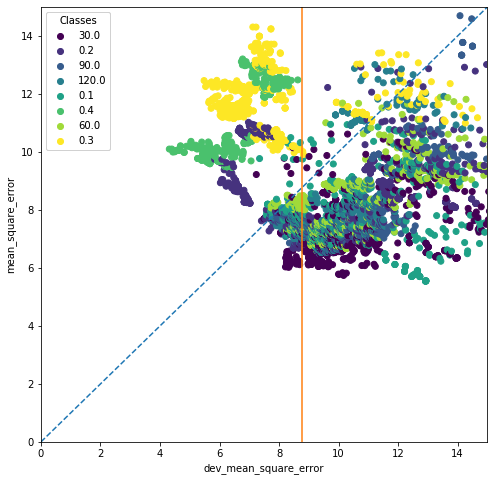

In [110]:
# Plot all models to get a sense of the mean square errors for each model - each dot represents one model
plot_data = results
fig, ax = plt.subplots(figsize=(8, 8))
column = 'test_size'
colours = pd.factorize(plot_data[column])[0]
scatter = ax.scatter(plot_data['dev_mean_square_error'], plot_data['mean_square_error'], 
                     c=colours)

ax.set_xlabel('dev_mean_square_error')
ax.set_ylabel('mean_square_error')
max_error = 15
ax.set_xlim((0, max_error))
ax.set_ylim((0, max_error))
ax.plot([0, max_error], [0, max_error], linestyle='dashed', label='45 degree line')
ax.plot([baseline_model.dev_mean_square_error, baseline_model.dev_mean_square_error], [0, max_error], label='Baseline dev MSE')
ax.legend()
leg = ax.legend(*scatter.legend_elements(), title="Classes")
[leg.get_texts()[i].set_text(label) for i, label in enumerate(pd.factorize(plot_data[column])[1])];
ax.add_artist(leg)

In [99]:
model_parameters

{'library_model': sklearn.linear_model.base.LinearRegression,
 'test_size': 30,
 'features': ('new_month', 'days_since_last_max_sq', 'new_year'),
 'train_test_split': <function __main__.train_test_split_by_time(X, y, test_size=0.1, **kwargs)>,
 'min_date': '2017-04-01',
 'max_date': '2019-07-01',
 'sample': 1.5,
 'location_weights': False}

On 01 September, there will be a minimum price of 130.87 cents
On 27 September, there will be a minimum price of 132.19 cents


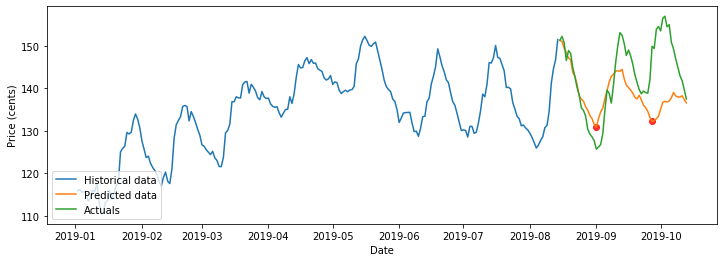

In [100]:
# Plot the predicted values against the validation set
model = FuelPricePredictor(**model_parameters)
model.fit(all_data)
model.predict(all_data, start_date='2019-01-01', end_date='2019-08-15', overlay_actuals=True, plot=True, minimum=True)
plt.savefig('screenshots/model_validation_predictions')

On 05 December, there will be a minimum price of 133.12 cents
On 10 November, there will be a minimum price of 135.95 cents


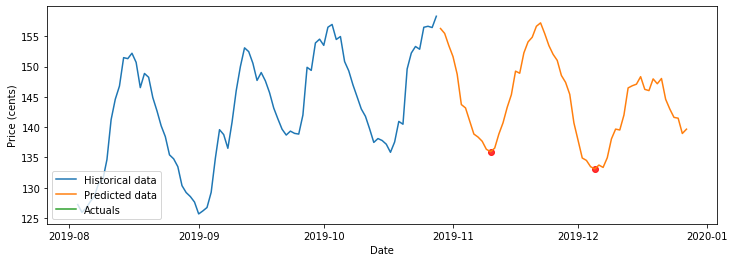

In [101]:
# Plot the predicted values against the future unknown data set
model = FuelPricePredictor(**model_parameters)
model.fit(all_data)
model.predict(all_data, start_date='2019-08-02', end_date='2019-10-30', overlay_actuals=True, plot=True, minimum=True)
plt.savefig('screenshots/model_future_predictions')

In [ ]:
### Appendix code

In [ ]:
dict(zip(range(len(model.feature_labels)), model.feature_labels))

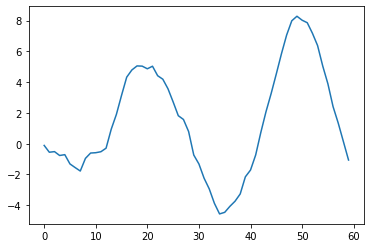

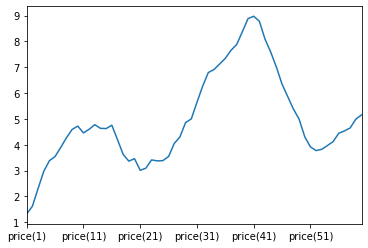

In [82]:
(model.y_preds - model.y_test).abs().mean(axis=0).plot()

(array([ 38., 101., 174., 292., 352., 391., 249., 138.,  54.,  11.]),
 array([-16.60801924, -13.22812612,  -9.848233  ,  -6.46833988,
         -3.08844676,   0.29144636,   3.67133948,   7.0512326 ,
         10.43112572,  13.81101884,  17.19091196]),
 <a list of 10 Patch objects>)

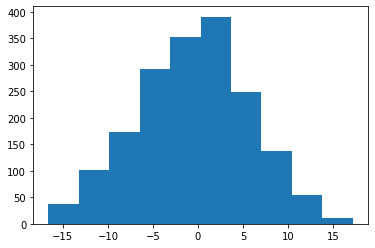

In [84]:
# Residual plot
plt.hist(model.residuals.values.flatten())

Text(0, 0.5, 'Actual')

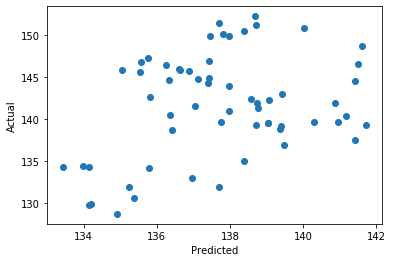

In [87]:
plt.scatter(model.y_preds.iloc[10, :], model.y_test.iloc[10, :])
plt.xlabel('Predicted')
plt.ylabel('Actual')

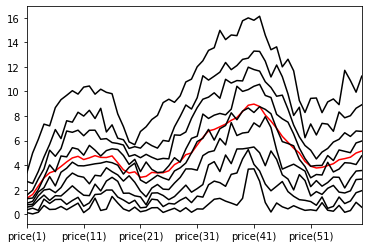

In [88]:
# Average predicted price deviation
(((model.y_preds - model.y_test)**2)**(1/2)).mean(axis=0).plot(color='red')
for i in np.linspace(0.05, 0.95, 9):
    (((model.y_preds - model.y_test)**2)**(1/2)).quantile(i, axis=0).plot(color='black')

In [89]:
(((model.y_preds - model.y_test)**2)**(1/2)).mean(axis=0)

price(1)     1.325349
price(2)     1.620742
price(3)     2.304882
price(4)     2.969505
price(5)     3.384618
price(6)     3.546582
price(7)     3.899421
price(8)     4.270721
price(9)     4.594206
price(10)    4.723725
price(11)    4.461167
price(12)    4.600782
price(13)    4.778755
price(14)    4.636811
price(15)    4.628493
price(16)    4.756943
price(17)    4.202706
price(18)    3.626914
price(19)    3.368122
price(20)    3.463573
price(21)    3.013629
price(22)    3.095432
price(23)    3.415030
price(24)    3.377234
price(25)    3.388128
price(26)    3.546372
price(27)    4.050946
price(28)    4.304399
price(29)    4.860684
price(30)    5.000454
price(31)    5.640921
price(32)    6.263749
price(33)    6.795332
price(34)    6.912813
price(35)    7.127867
price(36)    7.346335
price(37)    7.656224
price(38)    7.880466
price(39)    8.373186
price(40)    8.882364
price(41)    8.975465
price(42)    8.782955
price(43)    8.086966
price(44)    7.589478
price(45)    7.008604
price(46) 

6.246035387905012
11.660662339335339


<Figure size 864x216 with 0 Axes>

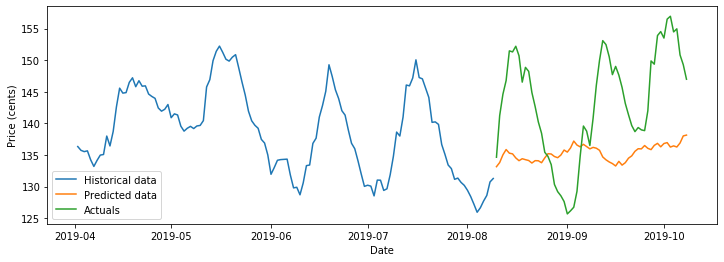

In [93]:
# Train a single model
model_parameters = {'library_model': sklearn.linear_model.base.LinearRegression,
                    'test_size': 10,
                    'features': ['new_month', 'new_year', 'days_since_last_max'],
                    'train_test_split': train_test_split_by_time,
                    'min_date': '2016-01-01',
                    'max_date': '2018-11-01',
                    'predictions': 60}
plt.figure(figsize=(12, 3))
model = FuelPricePredictor(**model_parameters)
model.fit(all_data)
model.predict(all_data, start_date='2019-04-01', end_date='2019-08-10', plot=True, overlay_actuals=True)
print(model.mean_square_error)
print(model.dev_mean_square_error)